**Remarks**

In this notebook, we weill learn about spam-messaging-classification using spaCy. Yeayy! I used this dataset to analyze (check: https://www.kaggle.com/uciml/sms-spam-collection-dataset). Let's started!

In [5]:
# importing libraries
# 1. NLP tools
import re 
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# 2. Preprocessing tools
import numpy as np
import pandas as pd

# 3. Modelling tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# 4. Visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
# !pip install --upgrade plotly

import warnings
warnings.filterwarnings('ignore')

In [7]:
# loading dataset
data = pd.read_csv('../content/spam-kaggle.csv',sep=',',names=['label','message'], encoding='ISO-8859-1')
data.reset_index(inplace=True)
data = data.drop(['label', 'level_2', 'message'], axis=1)
data = data.rename(columns={'level_0':'label',
                            'level_1':'message'})
data = data.drop([0], axis=0)
data.head()

,label,message
1,ham,"Go until jurong point, crazy.. Available only ..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4,ham,U dun say so early hor... U c already then say...
5,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# counting target
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [10]:
# checking null
data.isnull().sum()

label      0
message    0
dtype: int64

In [11]:
# showing the most data
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

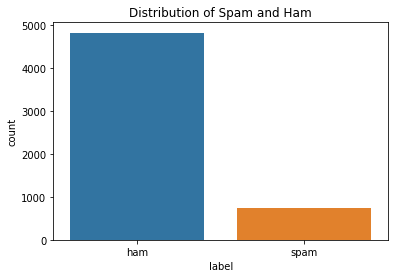

In [13]:
# show distribution target
sns.countplot(x='label', data=data)
data.loc[:, 'label'].value_counts()
plt.title('Distribution of Spam and Ham');

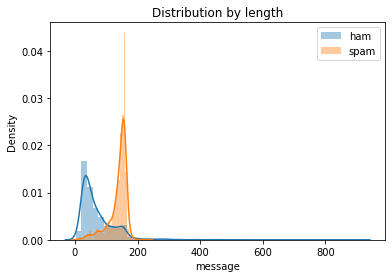

In [15]:
# show distribution length
ham = data[data.label == 'ham']['message'].str.len()
spam = data[data.label == 'spam']['message'].str.len()
sns.distplot(ham, label='ham')
sns.distplot(spam, label='spam')
plt.title('Distribution by length')
plt.legend();

In [16]:
# cleaning data
# 1. create punctuation marks
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
# 2. create list of stopwords
nlp = spacy.load('en')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [19]:
# 3. cleaning process
def text_data_cleaning(sentence):
  doc = nlp(sentence)
  # lemmatizing each token and converting into lowercase
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  cleaned_tokens = []
  for token in tokens:
    if token not in stopwords and token not in punct:
      cleaned_tokens.append(token)
  return cleaned_tokens

In [20]:
check = data['message'].apply(text_data_cleaning)
check.head()

1       [jurong, point, crazy, .., available, bugis, n...
2                [ok, lar, ..., joking, wif, u, oni, ...]
3       [free, entry, 2, wkly, comp, win, fa, cup, fin...
4                    [u, dun, early, hor, ..., u, c, ...]
5                                 [nah, think, usf, live]
                              ...                        
5568    [2nd, time, try, 2, contact, u., u, win, å£750...
5569                          [ì, b, esplanade, fr, home]
5570                        [pity, mood, ..., suggestion]
5571    [guy, bitching, act, like, interested, buy, we...
5572                                         [rofl, true]
Name: message, Length: 5572, dtype: object

In [21]:
# vectorizing the text
tfidf = TfidfVectorizer(tokenizer=text_data_cleaning)

In [29]:
# building classifier
spam_detect_model = MultinomialNB(alpha=1.0)

In [23]:
# splitting data
X = data.message
y = data.label

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
print("Shape of dataframe", (X_train.shape, X_test.shape))

Shape of dataframe ((5014,), (558,))


In [30]:
# creating pipeline of modelling
clf = Pipeline([("tfidf",tfidf),
                ("spam_detect_model",spam_detect_model)
                ])
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function text_data_cleaning at 0x7f99c70b4d40>,
                                 use_idf=True, vocabulary=None)),
                ('spam_detect_model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         ve

In [31]:
# check testing data
y_pred = clf.predict(X_test)

In [28]:
# checking accuracy
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print()
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

Confusion Matrix
[[491   0]
 [ 16  51]]

Accuracy Score 97.13%
Classification report:               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       491
        spam       1.00      0.76      0.86        67

    accuracy                           0.97       558
   macro avg       0.98      0.88      0.92       558
weighted avg       0.97      0.97      0.97       558



In [32]:
# checking accuracy alpha 1.0
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print()
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

Confusion Matrix
[[491   0]
 [ 16  51]]

Accuracy Score 97.13%
Classification report:               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       491
        spam       1.00      0.76      0.86        67

    accuracy                           0.97       558
   macro avg       0.98      0.88      0.92       558
weighted avg       0.97      0.97      0.97       558



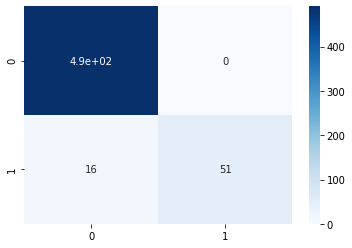

In [33]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')

In [36]:
# trying new messages
def pred(msg):
  prediction = clf.predict([msg])
  return print(prediction)

In [37]:
pred("I love to watch BTS meal in McD")

['ham']


In [38]:
pred("Elon musk on the ways to the moon")

['ham']


In [39]:
pred("Free ticket in a comp to win FA Cup final")

['spam']
